In [40]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [78]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import re
import gensim
import gensim.corpora as corpora
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD 
import pyLDAvis
pyLDAvis.enable_notebook()
import seaborn as sns
#from pyLDAvis import sklearn as sklearn_lda

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srimoyee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/srimoyee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [56]:
dataset = pd.read_csv('paper_data1.csv')

In [57]:
#function for lemmatization
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [58]:
# tokenization
tokenized_data = dataset['Abstract'].apply(lambda x: x.split())

In [59]:
# remove punctuation
tokenized_data = tokenized_data.apply(lambda x: [re.sub('[-,()\.!?]', '', item) for item in x])

tokenized_data = tokenized_data.apply(lambda x: [re.sub('[.]',' ',item) for item in x])

<>:2: DeprecationWarning: invalid escape sequence \.
<>:2: DeprecationWarning: invalid escape sequence \.
/var/folders/gn/hvgs6_rs6mg1q5nnlcsqvjd40000gn/T/ipykernel_24384/2440685948.py:2: DeprecationWarning: invalid escape sequence \.
  tokenized_data = tokenized_data.apply(lambda x: [re.sub('[-,()\.!?]', '', item) for item in x])


In [13]:
# turn to lowercase
tokenized_data = tokenized_data.apply(lambda x: [item.lower() for item in x])

In [33]:
# remove stop-words and short words
stop_words = stopwords.words('english')
stop_words.extend(['from','use', 'uses','user', 'users' 'well', 'study', 'survey', 'model','think', 'paper', 'research', 'method', 'result', 'results', 'propose', 'solution'])
tokenized_data = tokenized_data.apply(lambda x: [item for item in x if item not in stop_words and len(item)>3])

In [34]:
# lemmatize by calling lemmatization function
tokenized_data= tokenized_data.apply(lambda x: [get_lemma(item) for item in x])

In [35]:
# build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_data, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_data], threshold=10)  

In [36]:
# faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [37]:
# define functions for creating bigrams and trigrams.
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [38]:
# form Bigrams
tokenized_data_bigrams = make_bigrams(tokenized_data)

 # form Trigrams
tokenized_data_trigrams = make_trigrams(tokenized_data)

In [39]:
# de-tokenization
detokenized_data = []
for i in range(len(dataset)):
    t = ' '.join(tokenized_data_trigrams[i])
    detokenized_data.append(t)
    
dataset['clean_text']= detokenized_data 
documents = dataset['clean_text']


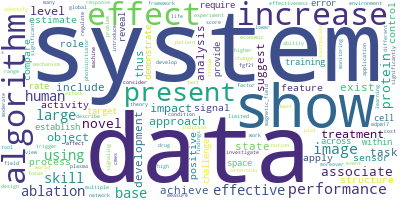

In [41]:
# import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(documents.values))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string)

# visualize the word cloud
wordcloud.to_image()

In [42]:
# set variables
no_terms = 1000

In [46]:
# NMF uses tf-idf Vectorizer
# initialise the tf-idf vectorizer with the English stop words
nmf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_terms, stop_words='english')
# fit and transform the text
nmf_matrix = nmf_vectorizer.fit_transform(documents)
# get features
nmf_feature_names = nmf_vectorizer.get_feature_names_out()

In [50]:
# LDA can only use raw term counts because it is a probabilistic graphical model
# initialise the count vectorizer with the English stop words
lda_vectorizer = CountVectorizer(max_df=0.5, min_df=2, max_features=no_terms, stop_words='english')
# fit and transform the text
lda_matrix = lda_vectorizer.fit_transform(documents)
# get features
lda_feature_names = lda_vectorizer.get_feature_names_out()


In [51]:
# LSA uses tf-idf also
# initialise the tf-idf vectorizer with the English stop words
lsa_vectorizer = TfidfVectorizer(max_df = 0.5, max_features= no_terms, stop_words='english', smooth_idf=True)
# fit and transform the text
lsa_matrix = lsa_vectorizer.fit_transform(documents)
# get features
lsa_feature_names = lsa_vectorizer.get_feature_names()

In [66]:
sns.set_style('whitegrid')

In [67]:
# %matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

/Users/srimoyee/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/srimoyee/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/srimoyee/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/srimoyee/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) in

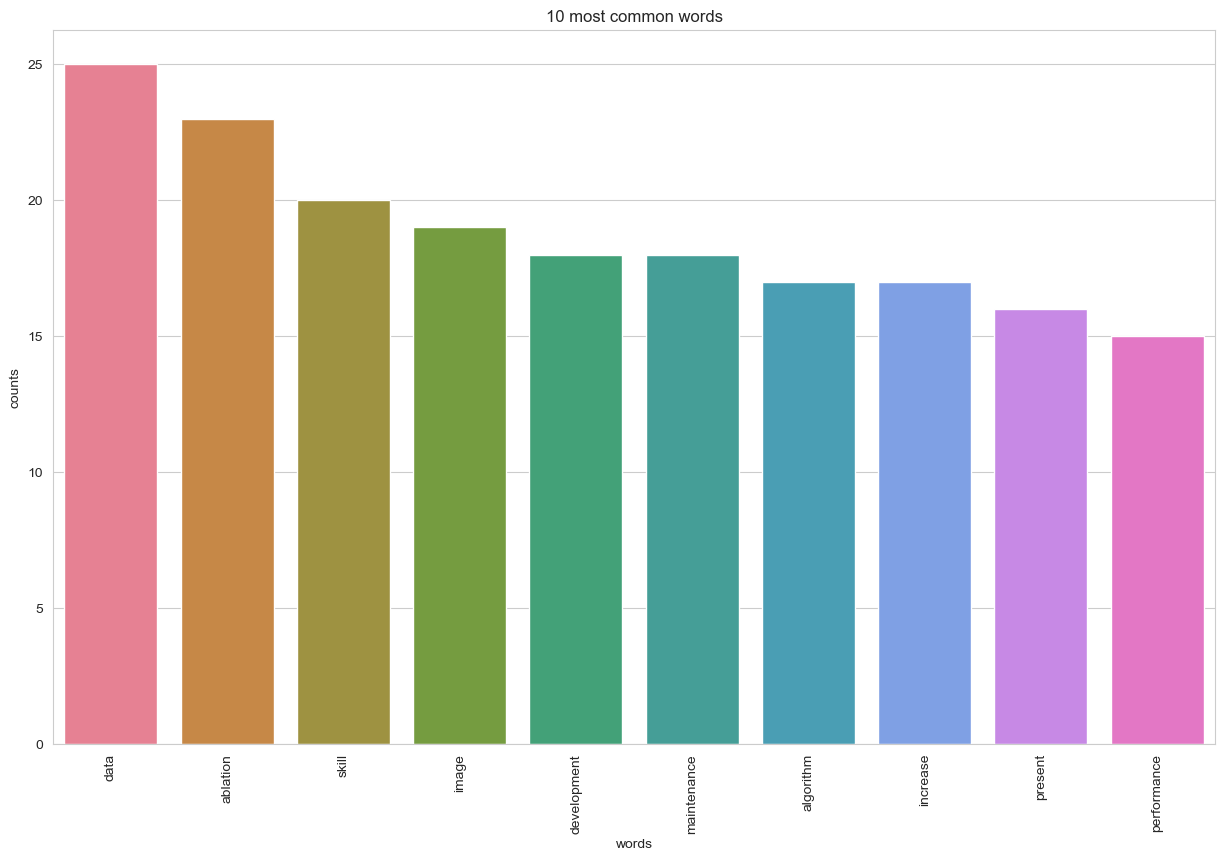

In [70]:
plot_10_most_common_words(lda_matrix, lda_vectorizer)

In [71]:
# set variables
no_topics = 10
no_top_words = 10

# custom function for displaying topics
def display_topic(model, feature_names, num_topics, no_top_words, model_name):    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    print("Model %s:" % model_name)
    word_dict = {};
    for i in range(num_topics):
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-no_top_words - 1:-1]
        words = [feature_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i)] = words;
    dict = pd.DataFrame(word_dict);
    dict.to_csv('%s.csv' % model_name)
    return dict

In [72]:
# run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(nmf_matrix)

/Users/srimoyee/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


In [75]:
lda_model = LatentDirichletAllocation(n_components= no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(lda_matrix)

In [79]:
lsa_model = TruncatedSVD(n_components=no_topics, algorithm='randomized', n_iter=100, random_state=122).fit(lsa_matrix)

In [81]:
display_topic(lda_model, lda_feature_names, no_topics, no_top_words, 'LDA_Model')

# display LDA topics and top words
display_topic(lsa_model, lsa_feature_names, no_topics, no_top_words, 'LSA_Model')

# display LDA topics and top words
display_topic(nmf_model, nmf_feature_names, no_topics, no_top_words, 'NMF_Model')

Model LDA_Model:
Model LSA_Model:
Model NMF_Model:


,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,trigger,cell,ablation,effect,task,algorithm,economic,image,differentially,level
1,target,regulate,treatment,moderate,best,theory,development,code,regulation,stage
2,class,activation,zone,patient,translation,family,activity,error,gene,employee
3,rate,signaling,technique,suggest,simple,problem,mobility,natural,role,training
4,embed,directly,patient,sensitivity,training,generalize,pattern,inverse,enrichment,behavior
5,close,death,signal,drug,ability,obtain,economy,property,associate,program
6,data,mediate,consist,chronic,language,fuzzy,visit,consider,protein,reaction
7,learning,pathway,monitoring,clinical,achieve,concern,outcome,segmentation,activity,learning
8,effectively,immune,risk,mark,incorporate,base,policy,version,plant,positive
9,design,response,liver,given,tool,particular,power,question,transduction,impact


In [82]:
lda_topic_values = lda_model.transform(lda_matrix)
nmf_topic_values = nmf_model.transform(nmf_matrix)
lsa_topic_values = lsa_model.transform(lsa_matrix)

dataset['LDA Topic'] = lda_topic_values.argmax(axis=1)
dataset['LSA Topic'] = lsa_topic_values.argmax(axis=1)
dataset['NMF Topic'] = nmf_topic_values.argmax(axis=1)
dataset.to_csv('results.csv')
dataset.head(50)

/Users/srimoyee/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


,ID,Title,Abstract,LDA Topic,LSA Topic,NMF Topic
0,1,Attention Is All You Need,The dominant sequence transduction models are ...,7,4,4
1,2,Integrating Latin America into the Global Econ...,Abstract: The 1990s marked a transformative er...,5,5,6
2,3,A pressure monitoring approach for pressure ul...,A pressure ulcer (PU) is a debilitating condit...,0,0,6
3,4,"On-body Sensing of Cocaine Craving, Euphoria a...",Drug addiction is a chronic brain-based disord...,1,0,9
4,5,A novel wearable device for automated real-tim...,Epilepsy is a neurological disorder that has a...,4,8,3
5,6,Industrial Control Protocol Fuzzing using Deep...,The security strength of Industrial Control Pr...,9,0,0
6,7,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the (k,ℓ)-pebble ...",7,6,5
7,8,Hopf Bifurcation in Asymmetric Ring Networks:\...,Hopf bifurcation in networks of coupled ODEs c...,3,5,0
8,9,Association of TRAIL receptor with phosphatase...,T cell receptor (TCR) signaling and T cell act...,5,3,1
9,10,A matter of new life and cell death: programme...,The mammalian ovary is a unique organ that dis...,0,3,1
